In [76]:
from pymatgen import MPRester, Element
from pymatgen.analysis.phase_diagram import PhaseDiagram, PDPlotter, PDEntry
import pickle
from pymatgen import *
from pymatgen.io.cif import *
from math import * 
from pymatgen.ext.matproj import *
import numpy as np
import keras.callbacks
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import pydot
from time import time
from keras.layers import Lambda, Input, Dense, Dropout
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K
from keras.utils.vis_utils import plot_model
import numpy as np
import matplotlib.pyplot as plt
from keras.callbacks import TensorBoard
import argparse

import os
from keras.utils.vis_utils import plot_model
import pydot_ng as pydot
% matplotlib inline
a = MPRester("T3RWfjVR1dBMcIZ5TCyX")
# b=a.query({"band_gap": {"$gt": .5 ,"$lt":1.4},"nsites":{"$lt":10}},["material_id"])
# ids=[i["material_id"] for i in b]
# materials=[]
# for i in ids:
#     materials.append(a.get_structure_by_material_id(i))
# print(materials[-1])
# import pickle
# filehandler = open("materials.obj","wb")
# pickle.dump(materials,filehandler)
# filehandler.close()


In [5]:
filenew = open("materials.obj",'rb')
object_file = pickle.load(filenew)
filenew.close()   

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 72)           0                                            
__________________________________________________________________________________________________
dense_264 (Dense)               (None, 60)           4380        encoder_input[0][0]              
__________________________________________________________________________________________________
dense_265 (Dense)               (None, 30)           1830        dense_264[0][0]                  
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 3)            93          dense_265[0][0]                  
__________________________________________________________________________________________________
z_log_var 

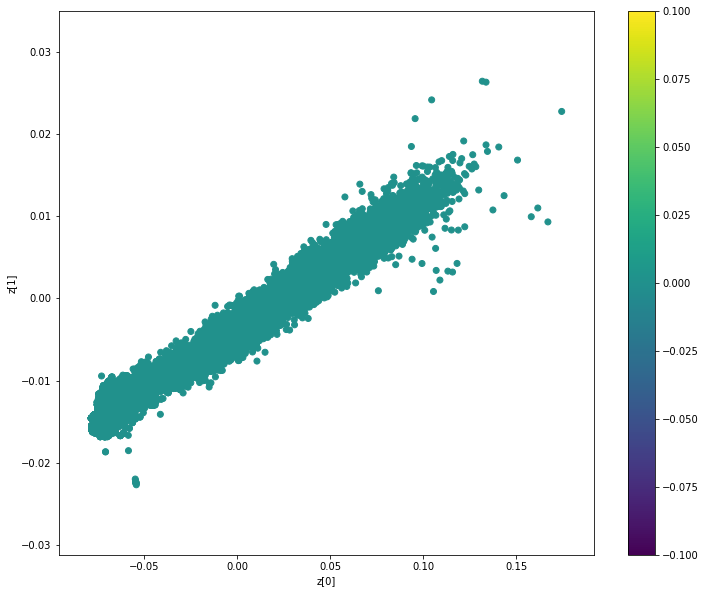

57854/57854 [==============================] - 4s 73us/step
training data results: 
2.3381824250679015


In [96]:
def makedata():
    def data(st):
        coords=np.round(st.frac_coords,m)*10**m
        coords[coords>(10**m-1)]=0
        count=0
        pos=np.zeros((10**m,10**m,10**m))
        for i in range(0,len(coords)):
            x,y,z=int(coords[i][0]),int(coords[i][1]),int(coords[i][2])
            pos[x,y,z]=st.species[i].number
        return pos
    leng=[]
    
    def data1(st):
        coords=np.asarray(st.frac_coords)
        out=[]
        for i in range(0,len(coords)):
            out.append(np.append(coords[i],st.species[i].number/100))
        leng.append(st.num_sites)
        #return out
        return coords
    
    m=1
    xdata=[]
    for i in object_file:
        xdata.append(np.asarray(data1(i)))
        
    n=50
    for i in range(0,len(xdata)):
        for j in range(0,n):
            perm = np.arange(xdata[i].shape[0])
            np.random.shuffle(perm)
            xdata.append(xdata[i][perm])
            
    for i in range(0,len(xdata)):
        new = np.zeros((max(leng),3))
        xdata[i]=np.asarray(xdata[i])
        new[:xdata[i].shape[0],:xdata[i].shape[1]] = xdata[i]
        xdata[i]=new
    
    return xdata

def plot_results(models,
                 data,
                 batch_size=128,
                 model_name="vae_mnist"):
  

    encoder, decoder = models
    x_test, y_test = data
    filename = "vae_mean.png"
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename)
    plt.show()
def sampling(args):
   

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon


xdata=makedata()
x_train, x_test, y_train, y_test = train_test_split(xdata,xdata, test_size=0.2, random_state=42)
original_dim = x_train[1].shape[1]*x_train[1].shape[0]
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
input_shape = (original_dim, )
intermediate_dim = 60
intermediate_dim2 = 30
intermediate_dim3 = 10
batch_size = 100
latent_dim = 3
epochs = 15


inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
x = Dense(intermediate_dim2, activation='relu')(x)
#x= Dropout(0.5)(x)
#x = Dense(intermediate_dim3, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
#x = Dense(intermediate_dim3, activation='relu')(latent_inputs)
x = Dense(intermediate_dim2, activation='relu')(latent_inputs)
#x= Dropout(0.5)(x)
#x = Dense(intermediate_dim2, activation='relu')(x)
x = Dense(intermediate_dim, activation='relu')(x)
outputs = Dense(original_dim, activation='sigmoid')(x)


decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)


outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

if __name__ == '__main__':

    models = (encoder, decoder)
    y_test=np.zeros((len(x_test)))
    data = (x_test, y_test)


    reconstruction_loss = mse(inputs, outputs)
    reconstruction_loss *= original_dim
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    vae_loss = K.mean(reconstruction_loss + kl_loss)
    vae.add_loss(vae_loss)
    vae.compile(optimizer='adam')
    vae.summary()
    plot_model(vae,
               to_file='vae_mlp.png',
               show_shapes=True)
    #tensorboard = TensorBoard(log_dir="logs/{}".format(time()))
    vae.fit(x_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(x_test, None),verbose=2)
    vae.save_weights('vae_mlp_mnist.h5')
    
    plot_results(models,
                 data,
                 batch_size=batch_size,
                 model_name="vae_mlp")
    metrics = vae.evaluate(x_train)
    print('training data results: ')
    print(metrics)
    #print(vae.predict(np.reshape(xdata[0], [-1, original_dim])).reshape(xdata[1].shape[0],xdata[1].shape[1]))
    #print(xdata[0])

In [97]:
# n = 2
# grid_x = np.linspace(-.5, 0.5, n)
# grid_y = np.linspace(-.5, .5, n)[::-1]
# new=[]
# for i, yi in enumerate(grid_y):
#     for j, xi in enumerate(grid_x):
#         z_sample = np.array([[xi, yi]])
#         x_decoded = decoder.predict(z_sample)
#         t=x_decoded[0].reshape(xdata[0].shape)
#         t[:,3]=np.round(100*np.round(t[:,3],2),0)
#         #print(t[:,3])
#         new.append(t)
y=54
test=vae.predict(np.reshape(xdata[y], [-1, original_dim])).reshape(xdata[1].shape[0],xdata[1].shape[1])
#test[:,3]=np.round(100*np.round(test[:,3],2),0)  
print(test)
print(xdata[y])
#print(xdata[y].shape)

[[0.40801555 0.39444908 0.39993197]
 [0.42727265 0.41751176 0.4205838 ]
 [0.4167219  0.4133501  0.40379807]
 [0.40262333 0.40183625 0.3903482 ]
 [0.33984524 0.3465101  0.32377902]
 [0.3021925  0.30294243 0.2900561 ]
 [0.2344294  0.24839514 0.23116867]
 [0.19965808 0.20824645 0.20962451]
 [0.08201846 0.08272668 0.07199856]
 [0.0083637  0.008786   0.00791836]
 [0.0083181  0.00830308 0.00859587]
 [0.00874573 0.00870502 0.00814481]
 [0.00482807 0.00569808 0.00543006]
 [0.00559353 0.00522725 0.00528698]
 [0.00515894 0.00527958 0.00453447]
 [0.00481959 0.00443715 0.00520748]
 [0.00576143 0.00460493 0.0041769 ]
 [0.00429656 0.00373676 0.00581513]
 [0.00431741 0.0046909  0.00379927]
 [0.00396193 0.00463783 0.00421895]
 [0.00477316 0.00448063 0.00437949]
 [0.00443994 0.00455036 0.0040819 ]
 [0.00411694 0.00458362 0.00444983]
 [0.00494334 0.0043792  0.0042415 ]]
[[0.39925676 0.39925676 0.39925676]
 [0.60074324 0.60074324 0.60074324]
 [0.21184359 0.21184359 0.21184359]
 [0.         0.         0. 

In [91]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt

import sys

import numpy as np

def makedata():
    def data(st):
        coords=np.round(st.frac_coords,m)*10**m
        coords[coords>(10**m-1)]=0
        count=0
        pos=np.zeros((10**m,10**m,10**m))
        for i in range(0,len(coords)):
            x,y,z=int(coords[i][0]),int(coords[i][1]),int(coords[i][2])
            pos[x,y,z]=st.species[i].number
        return pos
    leng=[]
    
    def data1(st):
        coords=np.asarray(st.frac_coords)
        out=[]
        for i in range(0,len(coords)):
            out.append(np.append(coords[i],st.species[i].number/100))
        leng.append(st.num_sites)
        return out
    
    m=1
    xdata=[]
    for i in object_file:
        xdata.append(np.asarray(data1(i)))
        
    n=100
    for i in range(0,len(xdata)):
        for j in range(0,n):
            perm = np.arange(xdata[i].shape[0])
            np.random.shuffle(perm)
            xdata.append(xdata[i][perm])
            
    for i in range(0,len(xdata)):
        new = np.zeros((max(leng),4))
        xdata[i]=np.asarray(xdata[i])
        new[:xdata[i].shape[0],:xdata[i].shape[1]] = xdata[i]
        xdata[i]=new
    
    return xdata


class GAN():
    def __init__(self):
        self.img_rows = 24
        self.img_cols = 4
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)


    def build_generator(self):

        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Flatten(input_shape=self.img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
        #(X_train, _), (_, _) = mnist.load_data()

        # Rescale -1 to 1
        #X_train = X_train / 127.5 - 1.
        X_train=makedata()
        X_train = np.expand_dims(X_train, axis=3)
        
        # Adversarial ground truths
        
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Generate a batch of new images
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Train the generator (to have the discriminator label samples as valid)
            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
           # if epoch % sample_interval == 0:
           #     self.sample_images(epoch)

    def sample_images(self, epoch):
         r, c = 5, 5
         noise = np.random.normal(0, 1, (r * c, self.latent_dim))
         gen_imgs = self.generator.predict(noise)
         print(gen_imgs)
#         # Rescale images 0 - 1
#         gen_imgs = 0.5 * gen_imgs + 0.5

#         fig, axs = plt.subplots(r, c)
#         cnt = 0
#         for i in range(r):
#             for j in range(c):
#                 axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
#                 axs[i,j].axis('off')
#                 cnt += 1
#         fig.savefig("images/%d.png" % epoch)
#         plt.close()
          

if __name__ == '__main__':
    gan = GAN()
    gan.train(epochs=200, batch_size=32, sample_interval=200)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_7 (Flatten)          (None, 96)                0         
_________________________________________________________________
dense_247 (Dense)            (None, 512)               49664     
_________________________________________________________________
leaky_re_lu_31 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_248 (Dense)            (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_32 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_249 (Dense)            (None, 1)                 257       
Total params: 181,249
Trainable params: 181,249
Non-trainable params: 0
_________________________________________________________________
____

100 [D loss: 0.261696, acc.: 93.75%] [G loss: 4.288880]
101 [D loss: 0.244411, acc.: 92.19%] [G loss: 4.090129]
102 [D loss: 0.231023, acc.: 95.31%] [G loss: 4.168906]
103 [D loss: 0.217697, acc.: 95.31%] [G loss: 4.216856]
104 [D loss: 0.284160, acc.: 92.19%] [G loss: 3.982068]
105 [D loss: 0.297208, acc.: 87.50%] [G loss: 4.189086]
106 [D loss: 0.188805, acc.: 98.44%] [G loss: 4.217290]
107 [D loss: 0.258306, acc.: 96.88%] [G loss: 4.200448]
108 [D loss: 0.323104, acc.: 90.62%] [G loss: 4.037677]
109 [D loss: 0.258238, acc.: 92.19%] [G loss: 4.328905]
110 [D loss: 0.196415, acc.: 98.44%] [G loss: 4.182894]
111 [D loss: 0.297451, acc.: 87.50%] [G loss: 3.891460]
112 [D loss: 0.246695, acc.: 93.75%] [G loss: 4.099694]
113 [D loss: 0.278084, acc.: 92.19%] [G loss: 4.118921]
114 [D loss: 0.220211, acc.: 100.00%] [G loss: 4.475305]
115 [D loss: 0.219258, acc.: 95.31%] [G loss: 4.390849]
116 [D loss: 0.253422, acc.: 95.31%] [G loss: 4.133366]
117 [D loss: 0.228382, acc.: 93.75%] [G loss: 4